In [41]:

import keras
keras.__version__

'2.12.0'

In [42]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)
     

In [43]:

from keras.datasets import imdb
from keras import preprocessing
from keras import utils as np_utils
#from tensorflow.keras.preprocessing.sequence import pad_sequences
#from keras.utils import pad_sequences
from keras.utils.data_utils import pad_sequences
# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 150

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.utils.pad_sequences(x_test, maxlen=maxlen)
     

In [44]:
print(len(x_train))

25000


In [45]:
import numpy as np
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 150, 8)            80000     
                                                                 
 flatten_8 (Flatten)         (None, 1200)              0         
                                                                 
 dense_10 (Dense)            (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 27s 41ms/step - loss: 0.5914 - acc: 0.7071 - val_loss: 0.4237 - val_acc: 0.8256
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 0.3310 - acc: 0.8651 - val_loss: 0.3211 - val_acc: 0.8652
Epoch 3/10
625/625 [===========================

In [46]:
from google.colab import drive
drive.mount('/content/gdrive')
     

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [47]:
import os
import shutil
%mkdir ../data
!wget -O ../data/aclImdb_v1.tar.gz http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -zxf ../data/aclImdb_v1.tar.gz -C ../data
imdb_dir = '/content/gdrive/MyDrive/ML Assignment 3/aclImdb'
train_dir = '/content/gdrive/MyDrive/ML Assignment 3/aclImdb/train'
#train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

mkdir: cannot create directory ‘../data’: File exists
--2023-04-16 19:11:07--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘../data/aclImdb_v1.tar.gz’

../data/aclImdb_v1. 100%[===================>]  80.23M  67.1MB/s    in 1.2s    

2023-04-16 19:11:08 (67.1 MB/s) - ‘../data/aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [48]:
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
#from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 150  # We will cut reviews after 150 words
training_samples = 100  # We will be training on 100 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


In [49]:
import os
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
glove_dir = '/content/gdrive/MyDrive/ML Assignment 3/glove6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [50]:
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
embedding_dim = 100
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
 
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

Found 0 unique tokens.


In [51]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
maxlen = 150
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 150, 100)          1000000   
                                                                 
 flatten_9 (Flatten)         (None, 15000)             0         
                                                                 
 dense_11 (Dense)            (None, 32)                480032    
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,480,065
Trainable params: 1,480,065
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [53]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
4/4 [==============================] - 2s 353ms/step - loss: 0.6929 - acc: 0.5900 - val_loss: 0.6931 - val_acc: 0.5060
Epoch 2/10
4/4 [==============================] - 1s 196ms/step - loss: 0.6923 - acc: 0.5900 - val_loss: 0.6931 - val_acc: 0.5060
Epoch 3/10
4/4 [==============================] - 1s 218ms/step - loss: 0.6921 - acc: 0.5900 - val_loss: 0.6931 - val_acc: 0.5060
Epoch 4/10
4/4 [==============================] - 1s 218ms/step - loss: 0.6921 - acc: 0.5900 - val_loss: 0.6931 - val_acc: 0.5060
Epoch 5/10
4/4 [==============================] - 1s 290ms/step - loss: 0.6919 - acc: 0.5900 - val_loss: 0.6931 - val_acc: 0.5060
Epoch 6/10
4/4 [==============================] - 1s 289ms/step - loss: 0.6918 - acc: 0.5900 - val_loss: 0.6931 - val_acc: 0.5060
Epoch 7/10
4/4 [==============================] - 1s 290ms/step - loss: 0.6916 - acc: 0.5900 - val_loss: 0.6931 - val_acc: 0.5060
Epoch 8/10
4/4 [==============================] - 1s 437ms/step - loss: 0.6914 - acc: 0.59

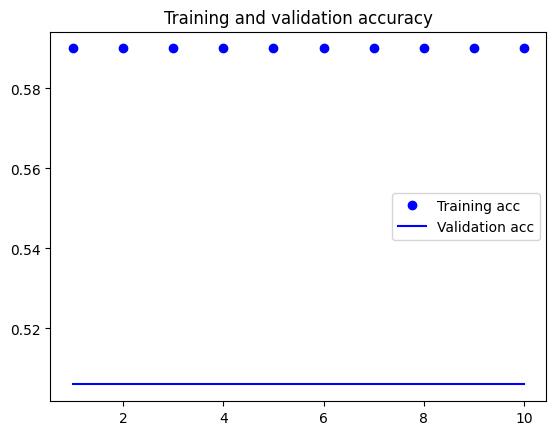

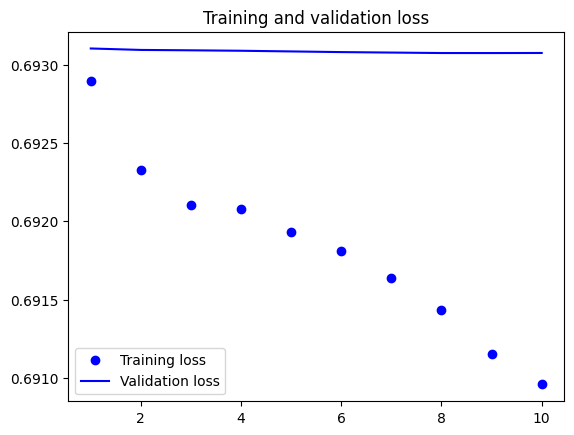

In [54]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [55]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [56]:

model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

785/785 [==============================] - 2s 3ms/step - loss: 0.6933 - acc: 0.4979


[0.6932905316352844, 0.49794843792915344]


**Hypertuning Embedding Layer 1 - 1000 Samples**


In [57]:
import keras
keras.__version__

'2.12.0'

In [58]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

In [59]:
from keras.datasets import imdb
from keras import preprocessing
from keras.utils.data_utils import pad_sequences

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 150

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = x_train[:1000]
y_train = y_train[:1000]

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.utils.pad_sequences(x_test, maxlen=maxlen)

In [60]:

print(len(x_train))

1000


In [61]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 150, 8)            80000     
                                                                 
 flatten_10 (Flatten)        (None, 1200)              0         
                                                                 
 dense_13 (Dense)            (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
25/25 [==============================] - 3s 110ms/step - loss: 0.6939 - acc: 0.5000 - val_loss: 0.6921 - val_acc: 0.5200
Epoch 2/10
25/25 [==============================] - 3s 127ms/step - loss: 0.6771 - acc: 0.7563 - val_loss: 0.6904 - val_acc: 0.5250
Epoch 3/10
25/25 [==============================]

**800 Samples**

In [62]:
from keras.datasets import imdb
from keras import preprocessing
from keras.utils.data_utils import pad_sequences

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 150

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = x_train[:800]
y_train = y_train[:800]

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.utils.pad_sequences(x_test, maxlen=maxlen)

In [63]:
print(len(x_train))


800


In [64]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 150, 8)            80000     
                                                                 
 flatten_11 (Flatten)        (None, 1200)              0         
                                                                 
 dense_14 (Dense)            (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
20/20 [==============================] - 3s 107ms/step - loss: 0.6942 - acc: 0.4828 - val_loss: 0.6905 - val_acc: 0.5250
Epoch 2/10
20/20 [==============================] - 2s 99ms/step - loss: 0.6767 - acc: 0.7188 - val_loss: 0.6898 - val_acc: 0.5188
Epoch 3/10
20/20 [==============================] 

**700 Samples**

In [65]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 150

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = x_train[:700]
y_train = y_train[:700]

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.utils.pad_sequences(x_test, maxlen=maxlen)

In [66]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 150, 8)            80000     
                                                                 
 flatten_12 (Flatten)        (None, 1200)              0         
                                                                 
 dense_15 (Dense)            (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
18/18 [==============================] - 2s 102ms/step - loss: 0.6926 - acc: 0.5089 - val_loss: 0.6962 - val_acc: 0.5071
Epoch 2/10
18/18 [==============================] - 2s 111ms/step - loss: 0.6747 - acc: 0.7482 - val_loss: 0.6970 - val_acc: 0.5071
Epoch 3/10
18/18 [==============================]

**900 Samples**

In [67]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 150

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = x_train[700:1600]
y_train = y_train[700:1600]

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.utils.pad_sequences(x_test, maxlen=maxlen)

In [68]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 150, 8)            80000     
                                                                 
 flatten_13 (Flatten)        (None, 1200)              0         
                                                                 
 dense_16 (Dense)            (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
23/23 [==============================] - 3s 105ms/step - loss: 0.6948 - acc: 0.4750 - val_loss: 0.6949 - val_acc: 0.4556
Epoch 2/10
23/23 [==============================] - 2s 98ms/step - loss: 0.6780 - acc: 0.7486 - val_loss: 0.6957 - val_acc: 0.4778
Epoch 3/10
23/23 [==============================] 

 After using both an embedding layer and a pretrained layer, I was able to determine that the plain embedding layer was the best approach. Not only was it the simplest method, but it produced the greatest accuracy (86.3% instead of 50.6% for the pretrained layer). After running some hypertuned embedding layers, I was able to determine that the regular embedding layer does better than the pretrained layer once the sample size reaches 800 samples. Anything below 800 samples, it would be best to use a pretrained word embedding layer.  ran the test originally with 1000 samples and pretrained layer, I was able to determine that the only was it the simplest method, but it produced the Accuracy incrementally increased and decreased the number of samples until I reached an accuracy slightly above the pretrained’s accuracy of 45.00%. The pretrained technique is best suited for small samples sizes, but once the sample size reaches 900, the best method to use is the regular embedding layer. 